In [2]:
# Allow to load the `adaptive cover` module from this notebook
import sys
sys.path.append("../custom_components")

from datetime import date, timedelta
from pvlib import solarposition
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from adaptive_cover.calculation import AdaptiveVerticalCover, AdaptiveHorizontalCover
from adaptive_cover.sun import SunData

Integration Calculations

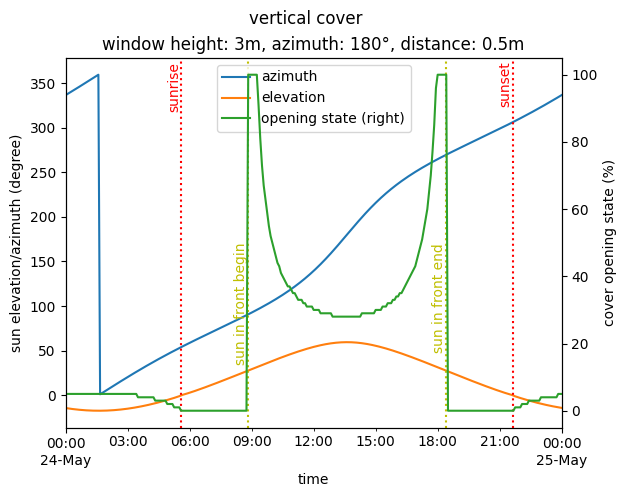

In [34]:
timezone = "CET"
lat = 51.5616455078125
lon = 5.08446288184867

maximum_position = 100

window_height = 3
window_distance = 0.5
windown_azimuth = 180
window_fov_left = 90
window_fov_right = 90

default_height = 60

class MockedHass:
    class MockedConfig:
        latitude = lat
        longitude = lon
        time_zone = timezone
        elevation = 0

    config = MockedConfig()
    data = {}

mocked_hass = MockedHass()

sun_data = SunData(hass=MockedHass, timezone=timezone)
sunrise_time = sun_data.location.sunrise()
sunset_time = sun_data.location.sunset()

sun_df = pd.DataFrame(
    {
        "azimuth": sun_data.solar_azimuth,
        "elevation": sun_data.solar_elevation,
    }
)
sun_df.set_index(sun_data.times, inplace=True)


def compute_cover_position(sun_data: pd.Series):
    # print(sun_data)
    vertical_cover = AdaptiveVerticalCover(
        hass=mocked_hass,
        timezone=timezone,
        sol_azi=sun_data["azimuth"],
        sol_elev=sun_data["elevation"],
        min_elevation=0,
        max_elevation=90,
        sunset_pos=30,
        sunset_off=0,
        sunrise_off=0,
        win_azi=windown_azimuth,
        fov_left=window_fov_left,
        fov_right=window_fov_right,
        h_win=window_height,
        distance=window_distance,
        h_def=default_height,
        blind_spot_on=False,
        blind_spot_left=0,
        blind_spot_right=0,
        blind_spot_elevation=0,
        max_pos=maximum_position,
    )

    return vertical_cover.calculate_percentage(), vertical_cover.valid


sun_df[["opening state", "sun_is_on"]] = sun_df.apply(compute_cover_position, axis=1, result_type="expand")

sun_in_front_begin=sun_df[sun_df["sun_is_on"]].iloc[0].name.to_pydatetime()
sun_in_front_end=sun_df[sun_df["sun_is_on"]].iloc[-1].name.to_pydatetime()


def plot(suptitle: str):
    ax = sun_df.plot(secondary_y=["opening state"], title=f"window height: {window_height}m, azimuth: {windown_azimuth}°, distance: {window_distance}m")

    ax.set_ylabel("sun elevation/azimuth (degree)")
    ax.right_ax.set_ylabel("cover opening state (%)")

    ax.figure.suptitle(suptitle)

    ax.axvline(sunrise_time, color='r', ls=':')
    ax.text(sunrise_time, 0.99, 'sunrise', color='r', ha='right', va='top', rotation=90, transform=ax.get_xaxis_transform())

    ax.axvline(sun_in_front_begin, color='y', ls=':')
    ax.text(sun_in_front_begin, 0.5, 'sun in front begin', color='y', ha='right', va='top', rotation=90, transform=ax.get_xaxis_transform())

    ax.axvline(sunset_time, color='r', ls=':')
    ax.text(sunset_time, 0.99, 'sunset', color='r', ha='right', va='top', rotation=90, transform=ax.get_xaxis_transform())

    ax.axvline(sun_in_front_end, color='y', ls=':')
    ax.text(sun_in_front_end, 0.5, 'sun in front end', color='y', ha='right', va='top', rotation=90, transform=ax.get_xaxis_transform())

plot("vertical cover")


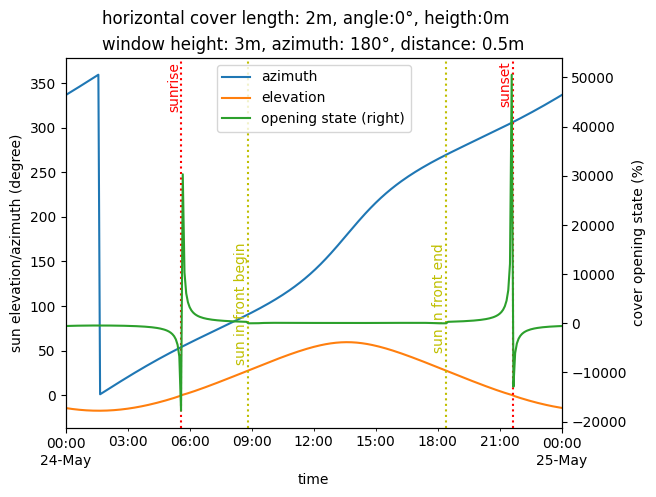

In [36]:
window_height = 3
window_distance = 0.5

cover_awning_length = 2
cover_awning_height = 0
cover_awning_angle = 0

def compute_cover_position(sun_data: pd.Series):
    # print(sun_data)
    horizontal_cover = AdaptiveHorizontalCover(
        hass=mocked_hass,
        timezone=timezone,
        sol_azi=sun_data["azimuth"],
        sol_elev=sun_data["elevation"],
        min_elevation=0,
        max_elevation=90,
        sunset_pos=30,
        sunset_off=0,
        sunrise_off=0,
        win_azi=windown_azimuth,
        fov_left=window_fov_left,
        fov_right=window_fov_right,
        h_win=window_height,
        distance=window_distance,
        h_def=default_height,
        blind_spot_on=False,
        blind_spot_left=0,
        blind_spot_right=0,
        blind_spot_elevation=0,
        awn_length=cover_awning_length,
        awn_angle=cover_awning_angle,
        max_pos=maximum_position,
    )
    return horizontal_cover.calculate_percentage(), horizontal_cover.valid


sun_df[["opening state", "sun_is_on"]] = sun_df.apply(compute_cover_position, axis=1, result_type="expand")

sun_in_front_begin=sun_df[sun_df["sun_is_on"]].iloc[0].name.to_pydatetime()
sun_in_front_end=sun_df[sun_df["sun_is_on"]].iloc[-1].name.to_pydatetime()

plot(f"horizontal cover length: {cover_awning_length}m, angle:{cover_awning_angle}°, height:{cover_awning_height}m")

Plots

In [ ]:
# start_date = '2022-06-05'
# end_date = '2022-06-06'
start_date = date.today()
end_date = start_date + timedelta(days=1)

times = pd.date_range(start=start_date, end=end_date, freq='5min',tz=timezone)
solpos = solarposition.get_solarposition(times, lat, lon)

slat_distance = 4
depth = 6

plot_calc = AdaptiveCoverCalculator(timezone,lat,lon,solpos['azimuth'],solpos['elevation'],win_azi,
    h_win,distance,fov_left,fov_right,def_height, angle, l_awn, slat_distance, depth)

Vertical

In [ ]:
blind_vertical = plot_calc.blind_state_perc()
# print(blind_vertical)
# plt.plot(blind_vertical, label='blind vertical', color='red')

Horizontal

In [ ]:
blind_horizontal = plot_calc.awn_state_perc()
# print(blind_horizontal)
# plt.plot(blind_horizontal, label='blind horizontal', color='green')

Tilt

In [ ]:
blind_tilt = plot_calc.calculate_tilt_angle
print(blind_tilt.values)
blind_tilt_per = plot_calc.tilt_state_perc()

[112.24018321 111.95899909 111.68931744 111.43056613 111.18221607
 110.94377744 110.71479676 110.49485383 110.28355932 110.08055246
 109.88549889 109.69808892 109.5180357  109.3450739  109.17895814
 109.01946198 108.86637666 108.7195102  108.57868655 108.44374473
 108.31453824 108.19093436 108.07281377 107.96006992 107.85260886
 107.75034877 107.65321981 107.56116398 107.47413493 107.39209801
 107.31503025 107.24292049 107.17576954 107.11359044 107.05640877
 107.00426308 106.95720537 106.91530169 106.87863289 106.84729536
 106.82140207 106.80108358 106.78648937 106.77778924 106.77517497
 106.77886219 106.78909253 106.80613604 106.83029405 106.86190229
 106.90133462 106.9490072  107.00538336 107.07097917 107.14636987
 107.23219745 107.32917922 107.43811817 107.55991466 107.6955807
 107.84625624 108.01322906 108.19795808 108.40210135 108.62755006
 108.87646923 109.15134791 109.45506007 109.79094057 110.16287888
 110.57543741 111.03400059 111.54496522 112.11598638 112.75629667
 113.477128

In [15]:
from astral import LocationInfo  # pylint: disable=import-outside-toplevel
from astral.location import Location
from astral.sun import sun
info = LocationInfo('','',"CET",lat,lon)
astral_location = Location(info)
#print(times.to_list)
print(astral_location.solar_azimuth(times[83]))
print((astral_location.sunset(start_date,local=False)))
test_astral = sun(info.observer, date=date.today())
#print(test_astral)
index = 0
azi_list = []
for i in times:
    azi_list.append(Location(info).solar_azimuth(times[index]))
    index += 1
df_azi = pd.DataFrame(azi_list)
df_azi = df_azi.set_index(times)
#print(df_azi)

89.85758163614543
2023-10-17 16:42:28.381622+00:00


In [55]:
elevation = 36

def get_astral_location(lat, lon, timezone, elevation
) -> tuple[astral.location.Location, astral.Elevation]:
    """Get an astral location for the current Home Assistant configuration."""
    from astral import LocationInfo  # pylint: disable=import-outside-toplevel
    from astral.location import Location  # pylint: disable=import-outside-toplevel

    latitude = lat
    longitude = lon
    timezone = str(timezone)
    elevation = elevation
    info = ("", "", timezone, latitude, longitude)

    # Cache astral locations so they aren't recreated with the same args
    dict = {}
    dict[info] = Location(LocationInfo(*info))

    return dict[info], elevation

print(get_astral_location(lat,lon,timezone,elevation))

(, tz=CET, lat=51.56, lon=5.08, 36)


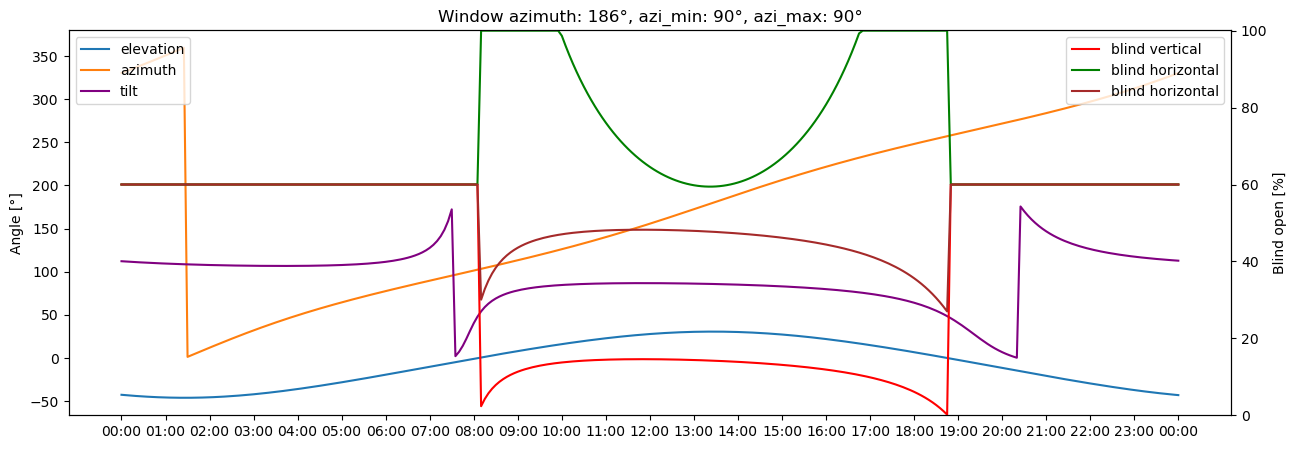

In [ ]:
time = solpos.index

ax, fig = plt.subplots(figsize=(15, 5))
plt.title(f"Window azimuth: {win_azi}°, azi_min: {fov_left}°, azi_max: {fov_right}°")
plt.plot(solpos['elevation'].values, label='elevation')
plt.plot(solpos['azimuth'].values, label='azimuth')
plt.plot(blind_tilt.values, label="tilt", color='purple')
plt.legend(loc='upper left')
plt.ylabel('Angle [°]')

ax2 = fig.twinx()
ax2.plot(np.clip(blind_vertical, 0, 100), label='blind vertical', color='red')
ax2.plot(np.clip(blind_horizontal, 0, 100), label='blind horizontal', color='green')
ax2.plot(np.clip(blind_tilt_per, 0, 100), label='blind horizontal', color='brown')
ax2.set_ylim(0, 100 + 0.1)
ax2.legend(loc='upper right')

plt.xticks(np.arange(0, len(time), 12), time[::12].strftime('%H:%M'), rotation=90)

# plt labels
plt.xlabel('Time [HH:MM]')
plt.ylabel('Blind open [%]')
plt.savefig('simulation/sim_plot.png')
plt.show()